In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [21]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, LSTM, Input, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
from urllib.request import urlopen
import urllib.request
import re 

Using TensorFlow backend.


In [3]:
def get_lyrics(artist,song_title):
    artist = artist.lower()
    song_title = song_title.lower()
    # remove all except alphanumeric characters from artist and song_title
    artist = re.sub('[^A-Za-z0-9]+', "", artist)
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title)
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who
        artist = artist[3:]
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html"
    
    try:
        content = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(content, 'html.parser')
        lyrics = str(soup)
        # lyrics lies between up_partition and down_partition
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->'
        down_partition = '<!-- MxM banner -->'
        lyrics = lyrics.split(up_partition)[1]
        lyrics = lyrics.split(down_partition)[0]
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').replace('<br/>','').strip()
        return lyrics
    except Exception as e:
        return "Exception occurred \n" +str(e)

In [4]:

def create_corpus(artist_name):
    url = 'http://lyrics.wikia.com/wiki/' + artist_name
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    count=0
    data=[]

    # Parse the data to get list of songs and urls
    for album in soup.find_all(class_='album-art'):
        count += 1
        for song in album.find_next('ol').children:
            try:
                a = re.search('\:(.*)', song.b.a['href'])
                data.append({
                    'url': song.b.a['href'],
                    'name': a.group(1)
                })
            except:
                continue
    df = pd.DataFrame(data, columns=["url","name"])
    print('Collecting {0} songs for {1}'.format(df.shape[0],artist_name))
    corpus = ''
    for ind, row in df.iterrows():
        #print('Collecting song: {}'.format(row['name']))
        corpus += '\n' + get_lyrics(artist_name,row['name'])
    print('Writing song corpus for {}'.format(artist_name))
    with open(artist_name+"_corpus.txt", "w") as text_file:
        text_file.write(corpus)



In [14]:
artist_name = 'Pink_Floyd'

In [15]:
def get_corpus_sequence(artist_name):
    from pathlib import Path
    my_file = Path(artist_name+'_corpus.txt')
    if not my_file.is_file():
        print('Corpus doesn\'t already exit for {}'.format(artist_name))
        create_corpus(artist_name)
    with open(artist_name+'_corpus.txt','r',encoding='utf8') as f:
        print('Gathering and processing sequence or text')
        text = f.read().lower().replace('\n',' \n ')
    text_seq = [word for word in text.split(' ') if word.strip != '']
    return text_seq

In [16]:
text_seq = get_corpus_sequence(artist_name)
#text = ''.join(text_seq)

Gathering and processing sequence or text


In [17]:
# Calculate word frequency
word_freq = {}
for word in text_seq:
    word_freq[word] = word_freq.get(word, 0) + 1
MIN_WORD_FREQUENCY = 3
ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

words = set(text_seq)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))

text_seq = [word for word in text_seq if word not in ignored_words]
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))


Unique words before ignoring: 635
Ignoring words with frequency < 3
Unique words after ignoring: 102


In [18]:
# cut the text in semi-redundant sequences of SEQUENCE_LEN words
STEP = 1
SEQUENCE_LEN = 5
sentences = []
next_words = []
ignored = 0
for i in range(0, len(text_seq) - SEQUENCE_LEN, STEP):
    # Only add sequences where no word is in ignored_words
    if len(set(text_seq[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
        sentences.append(text_seq[i: i + SEQUENCE_LEN])
        next_words.append(text_seq[i + SEQUENCE_LEN])
    else:
        ignored = ignored+1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 0
Remaining sequences: 1053


In [19]:
print('Vectorization...')
x = np.zeros((len(sentences), SEQUENCE_LEN, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1
x.shape, y.shape

Vectorization...


((1053, 5, 102), (1053, 102))

In [22]:
# build the model: a single LSTM
print('Build model...')
inputs = Input(shape=(SEQUENCE_LEN,len(words)))
X = LSTM(units=128, return_sequences=True)(inputs)
X = Dropout(0.4)(X)
X = LSTM(units=64)(X)
X = Dropout(0.4)(X)
X = Dense(len(words), activation='softmax')(X)

model = Model(inputs=inputs,outputs=X)

Build model...


In [37]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 102)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            118272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 102)               6630      
Total params: 174,310
Trainable params: 174,310
Non-trainable params: 0
_____________________________________________________

In [38]:
# Use genrator to create batches of training examples to train the model

In [39]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [43]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text_seq) - SEQUENCE_LEN - 1)
    generated = ''
    sentence = ' '.join(text_seq[start_index: start_index + SEQUENCE_LEN])
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(50):
        x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
        for t, word in enumerate(sentence.split(' ')):
            x_pred[0, t, word_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_word = indices_word[next_index]

        sentence = ' '.join(sentence.split(' ')[1:]) + ' ' +next_word

        sys.stdout.write(' ' + next_word)
        sys.stdout.flush()
    print()

In [51]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model_history = model.fit(x,y,batch_size=64,epochs=100,callbacks=[print_callback])

Epoch 1/100
1053/1053 [==============================] - 0s 437us/step - loss: 1.1580 - acc: 0.6828

----- Generating text after Epoch: 0
----- Generating with seed: "you're nearly a laugh 
"
you're nearly a laugh 
 you're you're really laugh 
 hey hey better think at the 
 apples and and 
 his and you you 
 you're all all 
 
 to to 
 on 
 and 
 man of for 
 the ho, in in 
 babe, how 
 leave leave running 
 but
Epoch 2/100
1053/1053 [==============================] - 1s 609us/step - loss: 1.0947 - acc: 0.6961

----- Generating text after Epoch: 1
----- Generating with seed: "can from 
 from 
"
can from 
 from 
 ha, you you you 
 you're hot it be 
 the cold on 
 to 
 and 
 to a feeling 
 he and the the stood 
 i with where barley 
  a what 
 but to laugh 
 he the 
 stood in a field where barley
Epoch 3/100
1053/1053 [==============================] - 1s 508us/step - loss: 1.1457 - acc: 0.6771

----- Generating text after Epoch: 2
----- Generating with seed: "
 you better run like"

 you

 on i more 
 he in the 
 in 
 the me feeling 
 i and as and 
 a with even your
Epoch 22/100
1053/1053 [==============================] - 0s 471us/step - loss: 0.9641 - acc: 0.7227

----- Generating text after Epoch: 21
----- Generating with seed: "are 
 you ha ha,"
are 
 you ha ha, charade you are 
 you when of is and 
 the nearly his 
 oh 
 
 you you you 
  her all day 
 to 
 to 
 on 
 up 
 and of 
 to are 
 madcap 
 even is the the 
 i 
 the
Epoch 23/100
1053/1053 [==============================] - 0s 408us/step - loss: 0.9291 - acc: 0.7255

----- Generating text after Epoch: 22
----- Generating with seed: "you can 
  
"
you can 
  
 and did and you for for in a 
  in 
 i good even 
 you 
 
 like the 
 
 of up 
 
 the and 
 on had 
 what up the 
 the to of they 
  the to all and so 
 up
Epoch 24/100
1053/1053 [==============================] - 0s 422us/step - loss: 0.9564 - acc: 0.7132

----- Generating text after Epoch: 23
----- Generating with seed: "
 and your 
 
"

 and your 
 
 

 can you a green field from a cold a from a 
 do you think you see 
 
 your 
 see for down 
 see your for 
 ha, your for out 
 
 for on the at out in 
 and they can your down stood where
Epoch 44/100
1053/1053 [==============================] - 0s 469us/step - loss: 0.8268 - acc: 0.7578

----- Generating text after Epoch: 43
----- Generating with seed: "
 and all but the"

 and all but the 
  
 in of the madcap 
  
 on the 
 two on 
 
 
 it 
 the the in on 
 oh  
 
 you ha oranges you oranges me 
 up to in 
 
 have from 
 
 a a you their field
Epoch 45/100
1053/1053 [==============================] - 1s 558us/step - loss: 0.8022 - acc: 0.7816

----- Generating text after Epoch: 44
----- Generating with seed: "
 to a madcap 
"

 to a madcap 
 he 
 the their in 
 i grows. on 
 the the 
 down i i i you how two two to leave ha ho, ha, you are 
 you you old ha ha, ha, are are are 
 
 run green is her 
 and to day 
 out
Epoch 46/100
1053/1053 [==============================] - 1s 516us/step 

1053/1053 [==============================] - 0s 448us/step - loss: 0.6754 - acc: 0.8215 0s - loss: 0.6523 - acc: 0.8

----- Generating text after Epoch: 64
----- Generating with seed: "and good with a 
"
and good with a 
 you're you're a laugh 
 
 cold a 
 as 
 and and a even your 
 with better your 
 your your your 
 he you're 
 a a a for he a 
  a do i and ha you do you are 
 when 
 your is
Epoch 66/100
1053/1053 [==============================] - 0s 441us/step - loss: 0.6613 - acc: 0.8234

----- Generating text after Epoch: 65
----- Generating with seed: "
 not he 
 he"

 not he 
 he stood in a field where barley grows. 
 on did green 
 he the in then they 
 on us here 
 he a eyes to stood nearly a cold where barley 
 
 did with a man in the 
 good ho, had 
 day to she in 

Epoch 67/100
1053/1053 [==============================] - 0s 404us/step - loss: 0.6230 - acc: 0.8319

----- Generating text after Epoch: 66
----- Generating with seed: "
 on 
 and then"

 on 
 and then 
 i old do

1053/1053 [==============================] - 1s 662us/step - loss: 0.5663 - acc: 0.8585

----- Generating text after Epoch: 85
----- Generating with seed: "
 the 
 two two"

 the 
 two two all up 
 please to but 
 
 grows. 
 in 
 the 
 me the 
 see were 
 
 and 
 the down madcap 
 by more their the 
 
 so you never 
 so up it 
 you in a for out her a his the
Epoch 87/100
1053/1053 [==============================] - 0s 436us/step - loss: 0.5660 - acc: 0.8471

----- Generating text after Epoch: 86
----- Generating with seed: "
 shall we a more"

 shall we a more 
 shall we the 
 shall we 
 the is 
 
 then it me old the think what apples and 
 
 
 and never feeling her her the the the in 
 had babe, the trip the in running 
 to is we 
 nearly not her 

Epoch 88/100
1053/1053 [==============================] - 1s 485us/step - loss: 0.5602 - acc: 0.8452

----- Generating text after Epoch: 87
----- Generating with seed: "down in the pig 
"
down in the pig 
 on 
 day on 
 
 and day 
 the as 


ValueError: arrays must all be same length

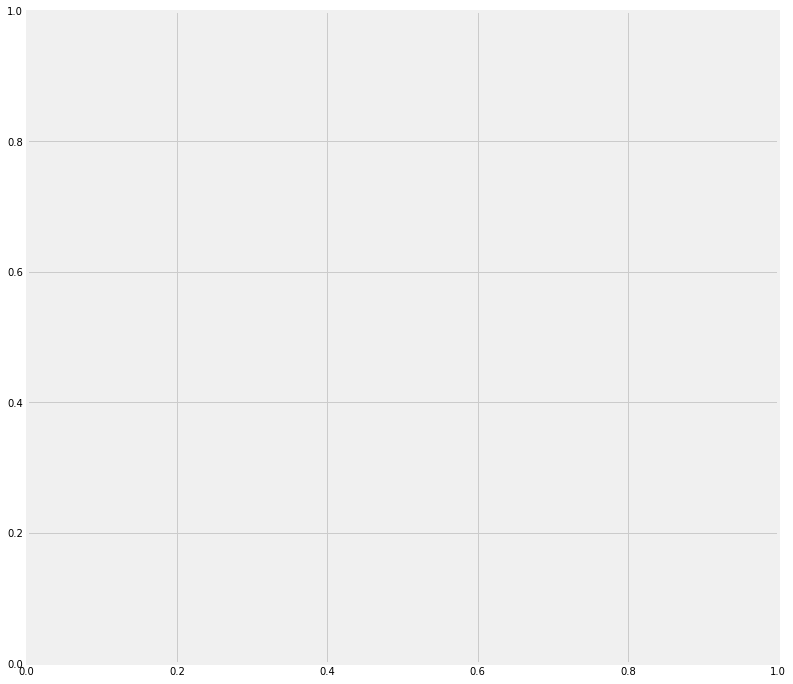

In [52]:
plt.subplots(figsize=(12,12))
sns.lineplot(x=range(100),y=model_history.history['acc'])
#sns.lineplot(x=range(20),y=model_history.history['val_acc'])